In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Wed Nov 25 11:28:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:

import os
import random
from shutil import copyfile

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
import pathlib

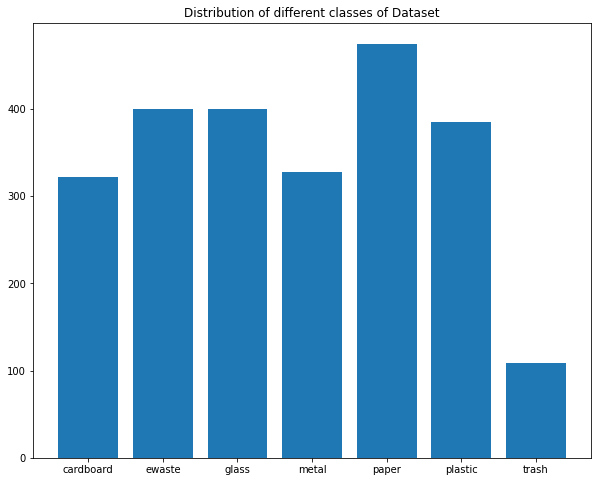

In [ ]:
image_folder = ['cardboard', 'ewaste', 'glass', 'metal', 'paper','plastic','trash']
nimgs = {}
for i in image_folder:
    nimages = len(os.listdir('/content/drive/MyDrive/dataset_resized/training/'+i+'/'))
    nimgs[i]=nimages
plt.figure(figsize=(10, 8))
plt.bar(range(len(nimgs)), list(nimgs.values()), align='center')
plt.xticks(range(len(nimgs)), list(nimgs.keys()))
plt.title('Distribution of different classes of Dataset')
plt.show()

In [ ]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

In [ ]:
img_width=256; img_height=256
batch_size=8

In [ ]:
TRAINING_DIR = '/content/drive/MyDrive/dataset_resized/training'
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=30,
                                   zoom_range=0.4,
                                   horizontal_flip=True
                                   )


In [ ]:
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    target_size=(img_height, img_width))

Found 2414 images belonging to 7 classes.


In [ ]:
VALIDATION_DIR = '/content/drive/MyDrive/dataset_resized/testing'

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              target_size=(img_height, img_width)
                                                             )

Found 608 images belonging to 7 classes.


In [ ]:
callbacks = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')
best_model = ModelCheckpoint('VGG16.h5', monitor='val_acc', verbose = 1, save_best_only = True)
#reduce_lr = ReduceLROnPlateau(patience=5, monitor='val_acc', factor=0.1, min_lr=0.0000001, mode='auto', verbose=1)

In [ ]:

vgg16_base = VGG16(include_top=False, 
                   input_tensor=None, input_shape=(img_height, img_width, 3))

58892288/58889256 [==============================] - 3s 0us/step


In [ ]:
print('Adding new layers...')
output = vgg16_base.get_layer(index = -1).output  
output = Flatten()(output)
# let's add a fully-connected layer
output = Dense(1024,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.2)(output)
output = Dense(1024,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.2)(output)
output = Dense(7, activation='softmax')(output)
print('New layers added!')

Adding new layers...
New layers added!


In [ ]:
vgg16_model = Model(vgg16_base.input, output)
for layer in vgg16_model.layers[:-7]:
    layer.trainable = False
vgg16_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)      

In [ ]:
# We can evaluate the model right now to see how it does before training it on our new images
initial_epochs = 3
validation_steps=32

loss0,accuracy0 = vgg16_model.evaluate(train_generator, steps = validation_steps)

32/32 [==============================] - 127s 4s/step - loss: 10.0033 - accuracy: 0.1562


In [ ]:
vgg16_model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics =['accuracy'])

In [ ]:
import numpy as np
from datetime import datetime
import time
#from sklearn import tree
#from sklearn.preprocessing import normalize, scale
from sklearn.metrics import accuracy_score
fmt = '%H:%M:%S'
def get_current_time():
    time.ctime()
    return time.strftime(fmt)
first = get_current_time()

In [ ]:
history = vgg16_model.fit_generator(train_generator,
                              epochs=30,
                              verbose=1,
                              validation_data=validation_generator,
                              callbacks = [callbacks, best_model]
                              )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
302/302 [==============================] - 1472s 5s/step - loss: 1.4660 - accuracy: 0.6118 - val_loss: 1.1690 - val_accuracy: 0.7007
Epoch 2/30
302/302 [==============================] - 58s 191ms/step - loss: 0.8770 - accuracy: 0.7374 - val_loss: 0.8464 - val_accuracy: 0.7895
Epoch 3/30
302/302 [==============================] - 58s 193ms/step - loss: 0.7538 - accuracy: 0.7676 - val_loss: 0.5902 - val_accuracy: 0.8306
Epoch 4/30
302/302 [==============================] - 58s 191ms/step - loss: 0.5769 - accuracy: 0.8036 - val_loss: 0.6034 - val_accuracy: 0.8421
Epoch 5/30
302/302 [==============================] - 58s 190ms/step - loss: 0.5329 - accuracy: 0.8244 - val_loss: 0.6413 - val_accuracy: 0.8454
Epoch 6/30
302/302 [==============================] - 57s 190ms/step - loss: 0.5406 - accuracy: 0.8161 - val_loss: 0.6749 - val_accuracy: 0.8191
Epoch 7/30
302/302 [==============================] - 5

In [ ]:
second = get_current_time()
print("Time taken to train(sec):", datetime.strptime(second, fmt) - datetime.strptime(first, fmt))

Time taken to train(sec): 0:43:19


In [ ]:
vgg16_model.evaluate(validation_generator)

76/76 [==============================] - 7s 87ms/step - loss: 0.5107 - accuracy: 0.8701


[0.5106815695762634, 0.8700658082962036]

In [ ]:
vgg16_model.metrics_names

['loss', 'accuracy']

In [ ]:
target_dir = '/content/drive/MyDrive/dataset_resized/target_dir'
if not os.path.exists(target_dir):
  os.mkdir(target_dir)
vgg16_model.save(target_dir + 'vgg16_model_256.h5')
vgg16_model.save_weights(target_dir + 'vgg16_weights_256.h5')


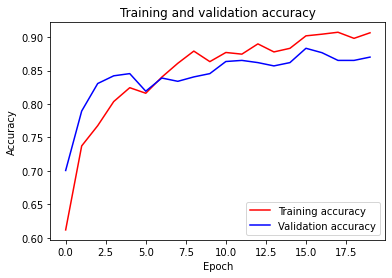

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()


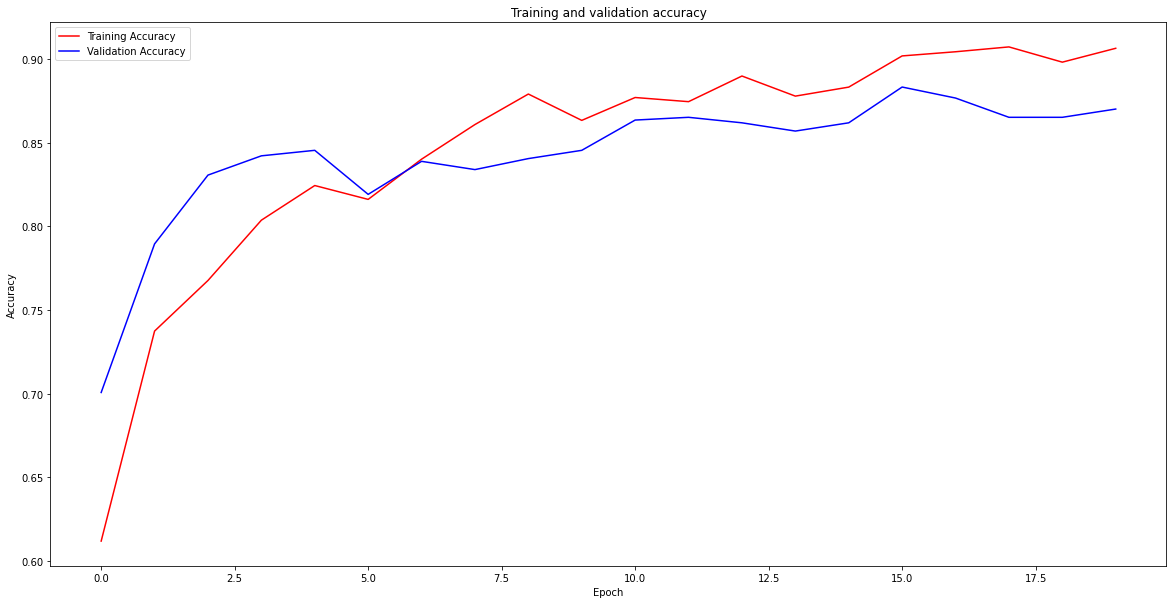

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.show()


Text(0.5, 1.0, 'Training and validation loss')

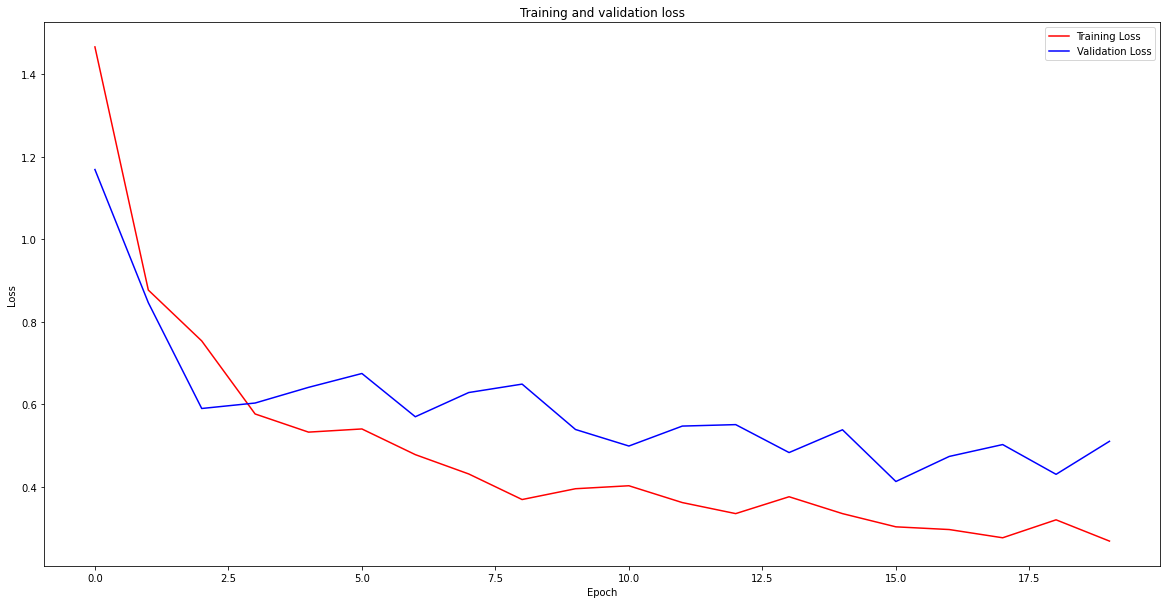

In [ ]:
fig2 = plt.figure(figsize=(20,10))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
from tensorflow.python.keras.applications import vgg16
from tensorflow.python.keras.applications.vgg16 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras import layers, models, Model, optimizers

In [ ]:
model = models.load_model("VGG16.h5")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes, figname,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
    plt.figure(figsize=(8,10))

    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                color='white' if cm[i, j] > thresh else 'black')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(figname)


Confusion matrix, without normalization


<Figure size 576x720 with 0 Axes>

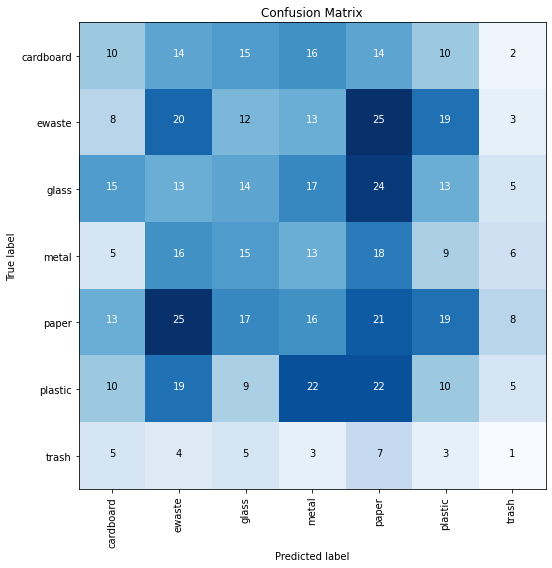

In [ ]:
Y_pred = vgg16_model.predict_generator(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(validation_generator.classes, y_pred)
plot_confusion_matrix(cm, classes = image_folder, title='Confusion Matrix', normalize=False, figname = 'Confusion_matrix_concrete.jpg')

In [ ]:
y_pred = vgg16_model.predict(validation_generator)

In [ ]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([5, 3, 0, 4, 2, 0, 1, 2, 4, 3, 1, 5, 2, 5, 0, 3, 6, 2, 4, 5, 3, 1,
       2, 1, 4, 3, 5, 5, 6, 1, 0, 2, 1, 3, 0, 4, 1, 1, 2, 4, 2, 2, 4, 6,
       1, 1, 3, 0, 4, 5, 0, 2, 2, 4, 4, 3, 3, 1, 1, 1, 5, 3, 3, 3, 2, 4,
       0, 4, 5, 3, 5, 3, 4, 4, 1, 2, 4, 4, 0, 0, 5, 6, 4, 5, 1, 1, 3, 4,
       3, 2, 3, 4, 4, 2, 4, 4, 1, 2, 2, 4, 4, 5, 0, 2, 4, 4, 4, 1, 3, 0,
       3, 3, 1, 0, 2, 6, 5, 2, 2, 4, 5, 3, 2, 1, 0, 1, 2, 1, 5, 3, 4, 3,
       1, 4, 0, 3, 3, 6, 3, 2, 3, 4, 4, 2, 5, 3, 1, 3, 2, 4, 1, 5, 4, 0,
       3, 1, 2, 0, 3, 2, 6, 1, 3, 0, 2, 2, 5, 0, 2, 6, 5, 5, 5, 2, 0, 4,
       2, 1, 1, 2, 3, 5, 4, 0, 1, 2, 2, 1, 3, 0, 4, 4, 5, 1, 1, 4, 0, 0,
       5, 1, 5, 3, 5, 5, 6, 1, 0, 4, 1, 3, 6, 3, 0, 3, 6, 3, 4, 5, 3, 5,
       5, 3, 1, 3, 2, 3, 4, 3, 2, 5, 0, 4, 2, 3, 5, 3, 2, 4, 4, 3, 3, 4,
       3, 4, 4, 1, 2, 3, 3, 1, 2, 5, 5, 3, 3, 3, 5, 3, 0, 3, 2, 1, 4, 4,
       4, 1, 1, 0, 5, 5, 0, 0, 3, 1, 2, 0, 5, 1, 1, 6, 2, 1, 3, 0, 2, 4,
       1, 5, 2, 1, 4, 1, 4, 0, 5, 4, 0, 5, 5, 5, 1,

In [ ]:
validation_generator.class_indices

{'cardboard': 0,
 'ewaste': 1,
 'glass': 2,
 'metal': 3,
 'paper': 4,
 'plastic': 5,
 'trash': 6}

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(256,256))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = vgg16_model.predict(images,batch_size=8)
  classes = np.argmax(classes, axis=1)
  print(fn)
  print(classes)

Saving plastic21.jpg to plastic21.jpg
plastic21.jpg
[5]


In [ ]:
import itertools

In [ ]:

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(8,10))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
target_names = []
for key in validation_generator.class_indices:
    target_names.append(key)

print(target_names)

['cardboard', 'ewaste', 'glass', 'metal', 'paper', 'plastic', 'trash']


Confusion Matrix
Normalized confusion matrix
Classification Report
              precision    recall  f1-score   support

   cardboard       0.14      0.11      0.12        81
      ewaste       0.20      0.22      0.21       100
       glass       0.23      0.20      0.21       101
       metal       0.12      0.15      0.13        82
       paper       0.15      0.16      0.15       119
     plastic       0.19      0.16      0.18        97
       trash       0.07      0.07      0.07        28

    accuracy                           0.16       608
   macro avg       0.16      0.15      0.15       608
weighted avg       0.17      0.16      0.17       608



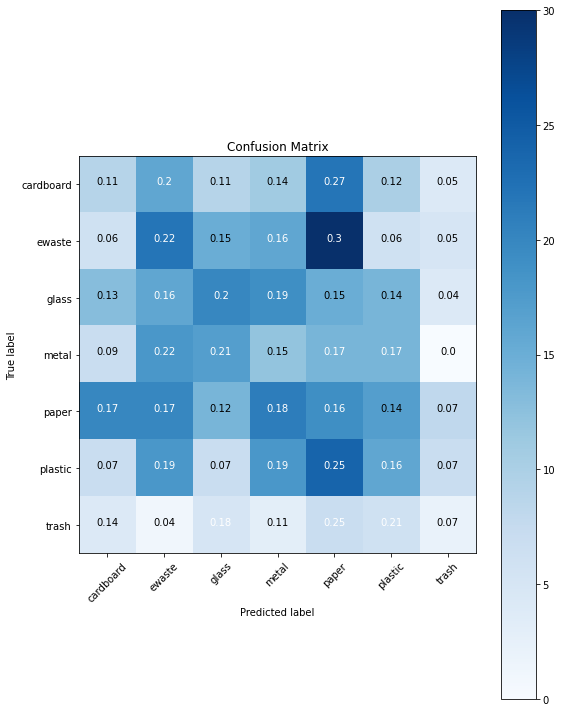

In [ ]:
Y_pred = vgg16_model.predict_generator(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(validation_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

#Print Classification Report
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))


In [ ]:
accuracy = accuracy_score(validation_generator.classes, y_pred)
print("Accuracy in test set: %0.1f%% " % (accuracy * 100))

Accuracy in test set: 14.6% 


In [ ]:
Y_pred = vgg16_model.predict_generator(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

img_nr = 0
for subdir, dirs, files in os.walk('/content/drive/MyDrive/dataset_resized (1)/testing/paper'):
    for file in files:
        img_file = subdir + '/' + file
        image = load_img(img_file,target_size=(img_height,img_width))
        pred_emotion = image_folder[y_pred[img_nr]]
        real_emotion = image_folder[validation_generator.classes[img_nr]]
        plt.figure()
        plt.title('Predicted: ' + pred_emotion + '\n' + 'Actual:      ' + real_emotion)
        plt.imshow(image)
        img_nr = img_nr +1